In [20]:
from pyspark import SparkContext
from operator import add
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, variance , lit,split,explode, col, when,udf,count
from pyspark.sql.types import IntegralType,StringType
import pyspark.sql.functions as F
import os 
from matplotlib import pyplot as plt
import pandas as pd

### Initialize a spark session

In [2]:
# Initialize a Spark session
spark = SparkSession.builder.appName("Spotify Analytics").getOrCreate()

In [3]:
def get_country_paths():
    root_directory = 'charts_data'  

    country_paths = {}

    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith("_chart_data.csv"):
                country_name = file.split('_')[0]
                country_path = os.path.join(root, file)
                country_paths[country_name] = country_path

    return country_paths


def get_country_df(country):
    # Specify the path to your CSV file
    filepath = country_paths[country]
    df = spark.read.option("header", "true").csv(filepath)
    return df


def get_audio_features_stats(country):
    #filepath = f"charts_data/charts_data_{continent}/{country}_chart_data.csv"
    filepath = country_paths[country]
    df = spark.read.option("header", "true").csv(filepath)
    columns_to_process = ["acousticness", "danceability","energy","instrumentalness","liveness","loudness","mode","speechiness","tempo","valence"]

    # Calculate the mean and variance for the specified columns
    mean_df = df.select([mean(col).alias(col) for col in columns_to_process])
    variance_df = df.select([variance(col).alias(col) for col in columns_to_process])

    # Add a 'statistic' column to distinguish between mean and variance

    mean_df = mean_df.select(lit("mean").alias("Statistic"),"*")
    variance_df = variance_df.select(lit("variance").alias("Statistic"),"*")

    # Union the two DataFrames
    result = mean_df.union(variance_df)

    # Show the result
    return result

def get_top_k_artists(country,k):
    #filepath = f"charts_data/charts_data_{continent}/{country}_chart_data.csv"
    filepath = country_paths[country]
    country_df = spark.read.option("header", "true").csv(filepath)

    artists_played_df = country_df.select("Artist","TrackName","TimesRepeated")

    # we split the appeared artists in each track. And keep the first as the main one.
    artists_played_df = artists_played_df.withColumn("Artist", split(artists_played_df["Artist"], ", "))

    artists_played_df = artists_played_df.withColumn("Artist", col("Artist")[0])
    
    # change the type of the column to integer 
    artists_played_df = artists_played_df.withColumn("TimesRepeated",artists_played_df.TimesRepeated.cast('int'))

    # Group by artists and calculate the total times played
    artist_counts = artists_played_df.groupBy("Artist").sum("TimesRepeated").withColumnRenamed("sum(TimesRepeated)", "total_times_played")


    # Sort by total times played in descending order and select the top 10
    top_k_artists = artist_counts.orderBy("total_times_played", ascending=False).limit(k)

    return top_k_artists


def song_distribution(song_name, country_files):
    # Create an empty dictionary to store the distribution
    distribution = {}
    total_count = 0
    for country, csv_file in country_files.items():
        # Read the CSV file into a Spark DataFrame
        df = spark.read.csv(csv_file, header=True)

        # Filter the DataFrame for the specified song name
        times_heard = df.filter(col("TrackName") == song_name).select("TimesRepeated").collect()

        n_heard = 0 if times_heard == [] else float(times_heard[0]['TimesRepeated'])
        total_count += n_heard
        # add the listened times to our dictionary
        # print(f"{country}: {n_heard}")
        distribution[country] = n_heard

    for country in distribution.keys():
        distribution[country] = distribution[country]/total_count

    return distribution




def visualize_song_popularity(song_name,distribution):
    # Extract country names and popularity percentages
    countries = list(distribution.keys())
    popularity = list(distribution.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(countries, popularity, color='royalblue')

    # Add labels and title
    plt.xlabel('Country')
    plt.ylabel('Popularity Percentage')
    plt.title(f'Song "{song_name}" Popularity by Country')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()



# Define a UDF to categorize release dates into decades
def categorize_decade(release_year):
    if release_year is None:
        return "Unknown"
    elif release_year < 1970:
        return "Before 70s"
    elif 1970 <= release_year < 1980:
        return "70s"
    elif 1980 <= release_year < 1990:
        return "80s"
    elif 1990 <= release_year < 2000:
        return "90s"
    elif 2000 <= release_year < 2010:
        return "Earlys 2000"
    elif 2010 <= release_year < 2020:
        return "2010-2020"
    else:
        return "2020-present"





In [4]:
country_paths = get_country_paths()

### Visualize the dataframe for a single country

In [5]:
country_df = get_country_df("sweden")
country_df.show(10)

+--------------------+--------------------+--------------------+-------------+------------+------------+------+----------------+----+--------+--------+----+-----------+-------+-------+------------+
|              Artist|           TrackName|             TrackId|TimesRepeated|acousticness|danceability|energy|instrumentalness| key|liveness|loudness|mode|speechiness|  tempo|valence|release_date|
+--------------------+--------------------+--------------------+-------------+------------+------------+------+----------------+----+--------+--------+----+-----------+-------+-------+------------+
|           Babblarna| Babblarnas vaggvisa|spotify:track:3Gy...|        296.0|       0.828|       0.299| 0.234|        0.000101|11.0|  0.0959| -13.009| 1.0|     0.0321|186.369|  0.333|  2023-09-01|
|              Avicii|          Wake Me Up|spotify:track:0nr...|        240.0|      0.0038|       0.532| 0.783|          0.0012| 2.0|   0.161|  -5.697| 1.0|     0.0523| 124.08|  0.643|  2013-01-01|
|         

### Get mean and variance from the audio features

In [6]:
stats = get_audio_features_stats("sweden")
stats.show()

+---------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+
|Statistic|       acousticness|        danceability|              energy|    instrumentalness|            liveness|          loudness|               mode|         speechiness|             tempo|           valence|
+---------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+
|     mean| 0.2693238186351488|  0.6593242343268252|  0.6159827523124338|0.011734261190133616| 0.17195182901767414|-7.256826962597624| 0.5632488697081791| 0.12195244554048505|119.37949691738599|0.5234426859843799|
| variance|0.06797859604371786|0.022149100187658918|0.028965699281423906|0.005321637114944656|0.017948042234064127| 6.816141030689112|0.25052680

### Get top 10 artists for a country

In [7]:
top_artists = get_top_k_artists("greece",10)
top_artists.show()

+-------------+------------------+
|       Artist|total_times_played|
+-------------+------------------+
|        Light|              2356|
|         SNIK|              2041|
|       TOQUEL|              1640|
|     Mad Clip|              1563|
|         RACK|              1364|
|           Fy|              1028|
|        Saske|               899|
| Dani Gambino|               893|
| Mente Fuerte|               860|
|Billie Eilish|               834|
+-------------+------------------+



### Given a song get the distribution over the countries.

In [8]:

song_name = "Wake Me Up"
#song_name = "FÖRSENT"
#song_name = "Shallow"
distribution = song_distribution(song_name, country_paths)

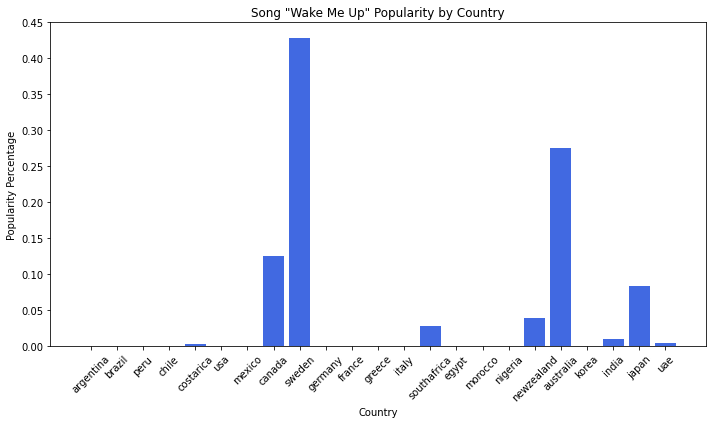

In [9]:
visualize_song_popularity(song_name,distribution)

### For each country distribution of release dates songs

In [26]:

def distribution_release_dates(country):
    custom_order = ["Before 70s", "70s", "80s", "90s", "Earlys 2000", "2010-2020", "2020-present"]

    country_df = get_country_df(country)

    # Register the UDF
    categorize_decade_udf = udf(categorize_decade, StringType())

    # Extract the year from the release_date column
    songs_df = country_df.withColumn("release_year", col("release_date").cast("int"))

    # Create a new column for the decade using the UDF
    songs_df = songs_df.withColumn("decade", categorize_decade_udf(songs_df["release_year"]))

    # Group the data by the 'decade' column and count the number of songs in each decade
    songs_by_decade = songs_df.groupBy("decade").agg(count("TrackName").alias("song_count"))


    
    return songs_by_decade

In [33]:
songs_by_decade = distribution_release_dates("germany")

In [34]:
songs_by_decade.show()

+------------+----------+
|      decade|song_count|
+------------+----------+
|2020-present|         3|
|         80s|         5|
|     Unknown|      5838|
|         90s|         2|
|  Before 70s|        10|
|   2010-2020|         3|
| Earlys 2000|         7|
+------------+----------+



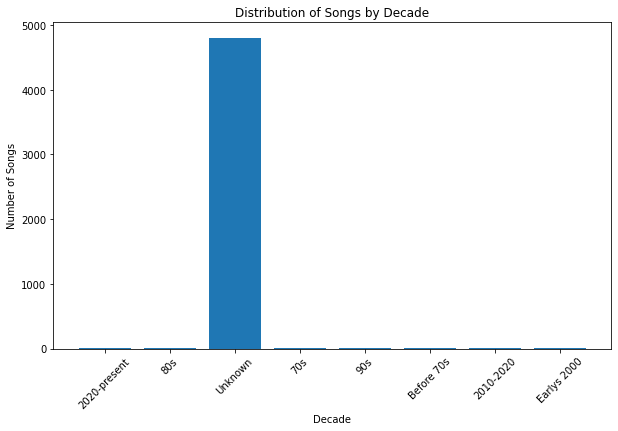

In [25]:
# Convert the PySpark DataFrame to a Pandas DataFrame
songs_by_decade_pd = songs_by_decade.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(songs_by_decade_pd['decade'], songs_by_decade_pd['song_count'])
plt.title('Distribution of Songs by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()